In [1]:
import os
import spacy
import string
import tqdm
import csv
from gensim.models import Word2Vec
import gensim
from collections import defaultdict
import math
import pandas as pd
import re
import ast
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import Counter
from scipy.spatial.distance import cosine
from wordfreq import top_n_list
from functions import preprocess_text
from functions import make_intervals
from functions import tfidf
from functions import get_decade
from functions import random_tfidf
from functions import words_intervals
from functions import get_mapping
from functions import projected_vector
from functions import laws_by_decade
from functions import projection
from functions import similar_words_projection
from functions import distance_to_projection
nlp = spacy.load("es_core_news_sm")
nlp.max_length = 2000000

We make a loop, where we input every law into the preprocessing function, and we store the results in a list

In [ ]:
files = os.listdir('./input/')[1:]
data = []
for file in tqdm.tqdm(files):
    filepath = './input/' + file
    match = re.search(r'Ley (\d+)_texto_(\d+)', file)
    if match:
        ley_numero = match.group(1)  
        año = match.group(2)

        with open(filepath, 'r', encoding='utf-8') as text_file:
            file_content = text_file.read()
            clean_content = preprocess_text(file_content, True, False)

        data.append((ley_numero, año, clean_content))
        
with open('./input/clean_data.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(data)
    
del file, file_content, filepath, files, ley_numero, match, nlp, text_file, año, clean_content

To avoid cleaning the data every time, we store it

In [2]:
csv.field_size_limit(10_000_000)
clean_data = []
with open('./input/clean_data.csv', 'r', encoding='utf-8', newline='') as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
        row[2] = ast.literal_eval(row[2])
        clean_data.append(row)

del reader, row, csv_file

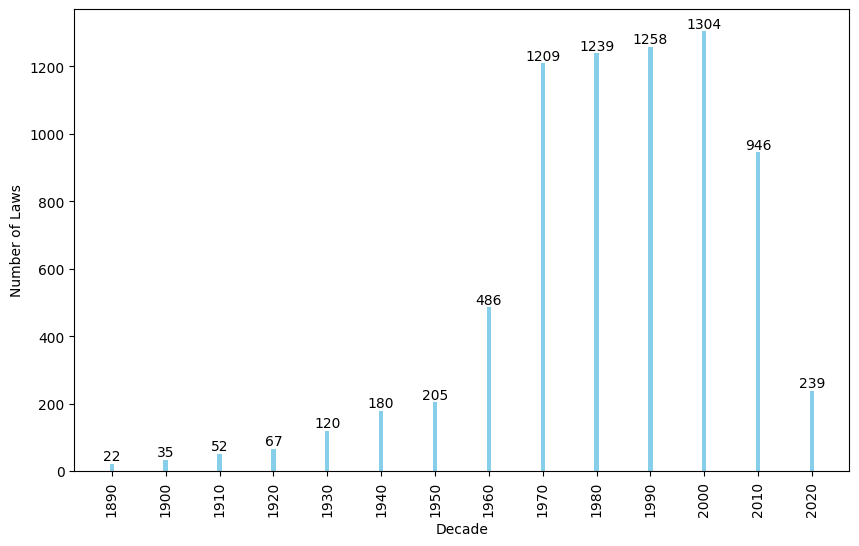

In [3]:
decades, counts = np.unique([get_decade(int(year)) for _, year, _ in clean_data], return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(decades, counts, width=0.8, color='skyblue') 
plt.xticks(decades, rotation=90)

for i, count in enumerate(counts):
    plt.text(decades[i], count+0.5, str(count), ha='center', va='bottom')

plt.xlabel('Decade')
plt.ylabel('Number of Laws')

plt.savefig('./output/laws_for_decade.png')

plt.show()

del decades, counts, i, count

As we can see, the amount of laws per decade are very unbalanced, this is probably due to the fact that the earlier on they were written, the less likely it is that they have been digitalized. We will have to make some decisions on how to balance these numbers for the analysis.

In [5]:
bootstrap = random_tfidf(clean_data, 111, 1000)
bootstrap = bootstrap.fillna(0)
bootstrap.to_parquet('./output/bootstrap.parquet')

100%|██████████| 1000/1000 [11:40<00:00,  1.43it/s]


In [3]:
bootstrap = pd.read_parquet('./output/bootstrap.parquet')
grouped_stats = bootstrap.groupby('index').agg(['mean', 'std'])

We want to know if a certain word is statistically different from its years mean, so we compute each words mean, each years mean and calculate a t statistic. Just in case, we use the absolute value of the standard deviation, so that it doesn't change the sign of the t-statistic

In [4]:
means = grouped_stats.xs('mean', axis=1, level=1)
stds = grouped_stats.xs('std', axis=1, level=1)
year_means = means.mean(axis=1)
adjusted_means = means.sub(year_means, axis=0)
t_stat = adjusted_means/ abs(stds)

del grouped_stats, stds, means, bootstrap, adjusted_means, year_means

Since in TFIDF a negative value means that the IDF part is giving that word a negative weight, we want to keep only those words that are significantly greater than their year means. Also, the significance level will be very high, with an $\alpha$ = 0.0005

$$
w_{x,y} = tf_{x,y}\times \log\left(\frac{N}{df_x}\right)
$$

In [5]:
stack = t_stat.stack()
significant = (stack > 3.30029).astype(int).loc[lambda x: x == 1].reset_index()
stopwords = nlp.Defaults.stop_words
significant = significant.loc[~significant['level_1'].isin(stopwords)]

del stack, t_stat

In [6]:
stopwords = ['buenos', 'republica', 'diciembre', 'enero', 
             'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio',
             'agosto', 'septiembre', 'octubre', 'noviembre',
             'aires', 'congreso','ley', 'artículo', 'argentina',
             'nacional', 'provincia', 'provincial', 'poder', 'decreto',
             'nación', 'nacional', 'nacionalidad', 'nacionales', 'infoleg',
             'cámara', 'diputado', 'senador', 'camara', 'decreto', 'norma',
             'sancion', 'sanción', 'deber', 'declarar', 'argentino']
important_words = [word for word in significant['level_1'].unique() if word not in stopwords and word not in top_n_list('es', 1000)]

del stopwords

# Word2Vec

### Most similar Words

In [7]:
def similar_word2vec(word, data, seed, n_laws=50, bootstrap_iterations=100, intervals = None):
    ''' 
    This function calculates the most similar words to a given word in a Word2Vec model using bootstrap.
    First selects n_laws randomly from each interval, then trains a Word2Vec model for each realization of said random selection.
    Finally, calculates the most similar words to the given word in each realization for each interval.
    Returns only those words that are similar to the given word across all realizations, along with their similarity score.
    '''
    intervals = make_intervals() if intervals is None else intervals
    similarities = []
    words_set = defaultdict(set)
    laws_by_decade_data = laws_by_decade(data, intervals)
    for iter in range(bootstrap_iterations):
        selected_laws = []
        random.seed(seed + iter)
        for laws in laws_by_decade_data.values():
            selected_laws.extend(random.sample(laws, n_laws))
        words_by_interval = words_intervals(selected_laws)
        for interval, words in words_by_interval.items():
            globals()[f"model_{interval}"] = Word2Vec(words, vector_size=300, window=5, workers=5)
        for interval in intervals:
            model_name = f"model_{interval[0]}_{interval[-1]}"
            model = globals()[model_name]
            
            if word in model.wv:
                similar_words = model.wv.most_similar(word, topn=30)
                words_only = [word for word, _ in similar_words if len(word) > 1]
                words_set[iter].update(words_only)
                similarities.extend([(word, model_name, similar_word, score) for similar_word, score in similar_words])
                
    common_words = set.intersection(*words_set.values())
    similarities = [(word, model_name, similar_word, score) for word, model_name, similar_word, score in similarities if similar_word in common_words]
    
    return similarities

In [16]:
similars = similar_word2vec('impuesto', clean_data, 111, 50, 20)

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def process_word(word):
	try:
		similars = similar_word2vec(word, clean_data, 111, 50, 100)
		return word, similars
	except Exception as e:
		print(e)
		return word, pd.DataFrame()
similars_results = defaultdict(pd.DataFrame)

with ThreadPoolExecutor(max_workers=6) as executor:
	futures = {executor.submit(process_word, word): word for word in important}
	for future in as_completed(futures):
		word, similars = future.result()
		similars_results[word] = similars

In [8]:
def similars_projection(word, data, seed, base_model_name, n_laws=50, bootstrap_iterations=100, intervals=None):
    '''
    This function calculates the most similar words to a given word in a Word2Vec model using bootstrap. 
    It takes the word vector from the base model, projects it into the space of the other models and finds the most similar words to the projected vector 
    in each of the other models for every iteration. It returns the similar words along with their similarity scores and the intervals.
    It only returns the words that are similar to the given word in all iterations.
	'''
 
    intervals = make_intervals() if intervals is None else intervals
    laws_by_decade_data = laws_by_decade(data, intervals)
    iter_similar_words = []
    models = [f"model_{interval[0]}_{interval[-1]}" for interval in intervals]
    words_set = defaultdict(set)
    for iter in range(bootstrap_iterations):
        selected_laws = []
        random.seed(seed + iter)
        for laws in laws_by_decade_data.values():
            selected_laws.extend(random.sample(laws, n_laws))
        words_by_interval = words_intervals(selected_laws)
        for interval, words in words_by_interval.items():
            globals()[f"model_{interval}"] = Word2Vec(words, vector_size=300, window=5, workers=5)
        base_model = globals()[base_model_name]
        
        for model in models:
            model_name = model
            if model != base_model_name:
                model = globals()[model]
            else:
                continue
            if word in base_model.wv:
                proj_similar_words = similar_words_projection(base_model, model, word)
                words_only = [word for word, _ in proj_similar_words if len(word) > 1]
                words_set[iter].update(words_only)
                iter_similar_words.extend((model_name, similar_word, score) for similar_word, score in proj_similar_words)
    
    common_words = set.intersection(*words_set.values())
    iter_similar_words = [(word, model_name, similar_word, score) for model_name, similar_word, score in iter_similar_words if similar_word in common_words]   
    return iter_similar_words


In [ ]:
def process_similar_proj(word):
	try:
		similars_proj = similars_projection(word, clean_data, 'model_1890_1930', 50, 20)
		return word, similars_proj
	except Exception as e:
		return word, pd.DataFrame()

similars_proj_results = defaultdict(pd.DataFrame)

with ThreadPoolExecutor(max_workers=6) as executor:
    futures = {executor.submit(process_similar_proj, word): word for word in random.sample(important_words, 10)}
    for future in as_completed(futures):
        word, similars_proj = future.result()
        similars_proj_results[word] = similars_proj

In [34]:
def distance_to_proj_boot(word, data, base_model_name, n_laws = 50, bootstrap_iterations = 100, intervals = None):
    '''
    This function calculates the cosine distance between a word vector from the base model and the projected word vector in the space of the other models.
    Also, if that word also happens to be in the other models, it calculates the cosine distance between the projected word vector and the actual word vector.
    All of this using bootstrap
    '''
    if not intervals:
        intervals = make_intervals()
    laws_by_decade_data = laws_by_decade(data, intervals)
    distance_to_proj = []
    models = [f"model_{interval[0]}_{interval[-1]}" for interval in intervals]
    for iter in range(bootstrap_iterations):
        selected_laws = []
        random.seed(111 + iter)
        for laws in laws_by_decade_data.values():
            selected_laws.extend(random.sample(laws, n_laws))
        words_by_interval = words_intervals(selected_laws)
        for interval, words in words_by_interval.items():
            globals()[f"model_{interval}"] = Word2Vec(words, vector_size=300, window=5, workers=5)
        base_model = globals()[base_model_name]
        
        for model in models:
            if model != base_model_name:
                model = globals()[model]
            else:
                continue
            if word in base_model.wv:
                dist_proj_to_original = distance_to_projection(base_model, model, word)
                if word in model.wv:
                    f = projected_vector(base_model, model, word)
                    v = model.wv[word]
                    dist_proj_to_actual = 1 - cosine(v, f)
                else:
                        dist_proj_to_actual = None          
        if dist_proj_to_original:
            distance_to_proj.append([dist_proj_to_original, dist_proj_to_actual])
    
    return distance_to_proj

In [10]:
def process_distance_to_proj(word):
	try:
		distance_proj = distance_to_proj_boot(word, clean_data, 'model_1890_1930', 50, 20)
		return word, distance_proj
	except Exception as e:
		print(e)
		return word, pd.DataFrame()

distance_to_proj_results = defaultdict(pd.DataFrame)

with ThreadPoolExecutor(max_workers=6) as executor:
	futures = {executor.submit(process_distance_to_proj, word): word for word in random.sample(important_words, 3)}
	for future in as_completed(futures):
		word, distance_proj = future.result()
		distance_to_proj_results[word] = distance_proj

# Case Study

In [4]:
intervals = {
    'Agroexportador': list(range(1890, 1931, 1)),
    'ISI': list(range(1931, 1958, 1)),
    'Desarrollismo': list(range(1958, 1976, 1)),
    'Dictadura': list(range(1976, 1983, 1)),
    'Democracia': list(range(1983, 2000, 1)),
    'SXXI': list(range(2000, 2025, 1))
    }

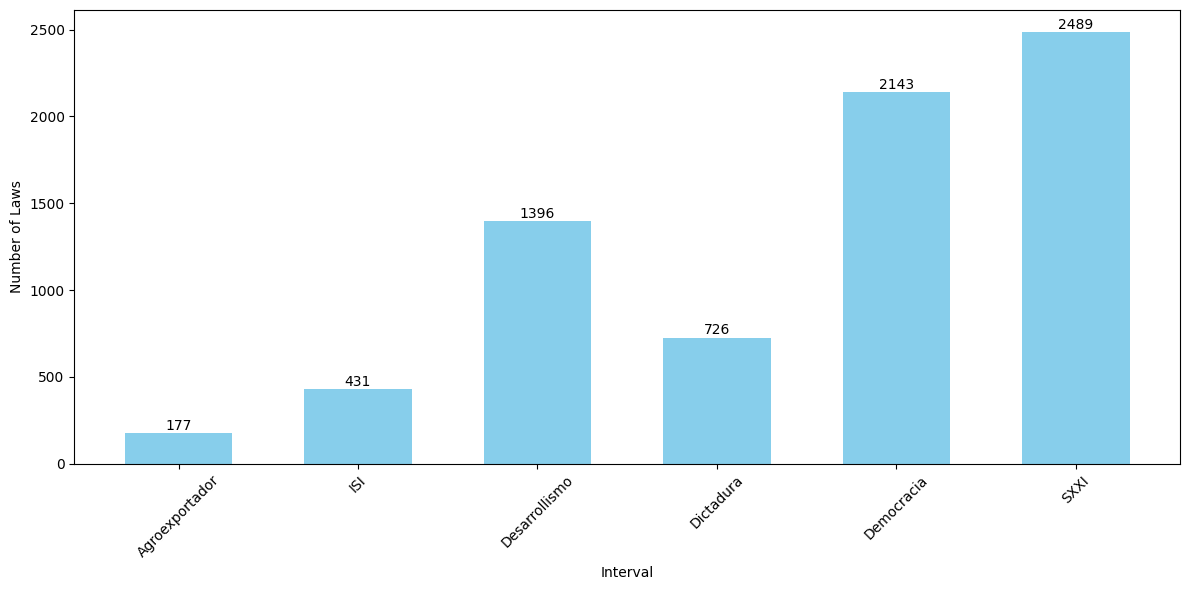

In [5]:
interval_labels = [get_interval(int(year), intervals=intervals) for _, year, _ in clean_data]
unique_intervals, counts = np.unique(interval_labels, return_counts=True)

ordered_intervals = list(intervals.keys()) 
ordered_counts = [counts[list(unique_intervals).index(interval)] if interval in unique_intervals else 0 for interval in ordered_intervals]

plt.figure(figsize=(12, 6))
plt.bar(ordered_intervals, ordered_counts, width=0.6, color='skyblue')
plt.xticks(rotation=45)

for i, count in enumerate(ordered_counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')

plt.xlabel('Interval')
plt.ylabel('Number of Laws')

plt.tight_layout()
plt.savefig('./output/laws_by_interval.png')
plt.show()

In [ ]:
intervals = [interval for interval in intervals.values()]

In [ ]:
bootstrap = random_tfidf(clean_data, 111, 750, intervals= intervals)
bootstrap = bootstrap.fillna(0)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [12:54<00:00,  1.29it/s]
